In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, History, Callback, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [2]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    DF = []
    for i in range(d):
        if i == 0:
            DF = np.concatenate((df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [3]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    X_train = DFscaled
    Y_train = Dyscaled

    #Train test split
    train_portion = 0.8
    n_timesteps = len(X_train[:,0])
    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]

    n_features = int(x_train.shape[1]/d)
    
    #Reshape training data into 3D array as required by the LSTM layer
    #Input shape is: (n_timesteps, d, n_features)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [4]:
def initialize_model(n_units, x_train, y_train, lr, n_layers):
    model = Sequential()
    
    #Add hidden layers, return_sequences=True if next layer is LSTM, False otherwise
    if n_layers == 1:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
        
    elif n_layers == 2:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        model.add(LSTM(n_units))
    else: 
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        for layer in range(n_layers-1):
            model.add(LSTM(n_units, return_sequences = True))
        model.add(LSTM(n_units))
    
    
    #model.add(Dropout(0.1))
    
    model.add(Dense(len(y_train[0,:]))) #Output Layer
    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    #Define callbacks
    history = History()
    earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')
    callback_list = [earlystop, history]
    return model, callback_list

In [5]:
def get_error(predictions, y_test):
    #Squared error is integrated numerically in space for each timestep and summed
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [6]:
def independent_predictions(x_test, my_model):

    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
    for i in range(future_timesteps): 
        pred = my_model.predict(input_i_reshaped) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
        input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
        
    return preds

In [7]:
def independent_batch(x_batch):

    input_i = np.copy(x_batch[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_batch[:,0,0])

    force = np.copy(x_batch[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
    
    ind_batch = np.zeros([future_timesteps, d, n_features])
    ind_batch[0] = input_i_reshaped[0]
    
    for i in range(future_timesteps): 
        pred = model.predict(input_i_reshaped) #Predict next timestep
        
        if i < future_timesteps - 1:
            input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
            input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
            input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

            input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
            ind_batch[i+1] = input_i_reshaped[0]
        
    return ind_batch

In [8]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [9]:
def get_batch_scalers(n_batches, training_set):
    
    #Simple version
    for i in range(n_batches):
        
        df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(i+1) + '.csv')
        df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(i+1) + '.csv')
        df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(i+1) + '.csv')
        
        if i == 0:  
            x_range = df_D.values.max() - df_D.values.min()
            imax = i
        
        else:
            new_x_range = df_D.values.max() - df_D.values.min()
            
            if new_x_range > x_range:
                x_range = new_x_range
                imax = i
                
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(imax+1) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(imax+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(imax+1) + '.csv')
    
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    return x_scaler, y_scaler

In [10]:
#columns = ['training set', 'n_layers', 'height', 'epochs', 'batch size', 'learning rate', 'early stopping', 'stop loss', 'Training Error', 'Test Error',
#           'Ind test error', 'Ind train error', 'Training time', 'Total time']
#df = pd.DataFrame(columns = columns)

#df.to_csv('../results/RNN_velocity_results.csv')

In [11]:
def get_batch(x_train, y_train, batch_size):
    
    start = random.randint(0,len(x_train)-batch_size)
    
    x_batch = x_train[start:start+batch_size]
    y_batch = y_train[start:start+batch_size]
    
    return x_batch, y_batch

In [12]:
random.randint(0,100)

0

In [14]:
#Select training set
training_set = 'rr'
iteration = 0
d=10

x_scaler, y_scaler = get_batch_scalers(1, training_set) #Get global scalers

#Import training data
df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(iteration+1) + '.csv')
df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(iteration+1) + '.csv')
df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(iteration+1) + '.csv')

#Prepare training data
DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)

#Split into train and test set
x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)


In [15]:
class Ind_pred(Callback):
    
    def on_epoch_end(self, epoch, logs={}):

        input_i = np.copy(x_test[0,:,:]) #Initial conditions
        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

        future_timesteps = len(x_test[:,0,0])-1
        preds = np.zeros([future_timesteps, n_y])

        force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
        
        for i in range(future_timesteps): 
            pred = self.model.predict(input_i_reshaped) #Predict next timestep
            preds[i, :] = pred[0] 

            input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
            input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
            input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

            input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

        
        error = 0
        for i in range(len(preds[:,0])):
            error += np.trapz((y_test[i,:n_nodes] - preds[i,:n_nodes])**2, x)
        
        info = {'ind error': error}
        u_ind_errors.append(error)
        
        logs['ind_error'] = error
            
        print(info)
    
    #def on_batch_end(self, batch, logs={}):
    #    print(batch)

In [16]:
######################### BATCH TRAINING ########################################

n_batches = 1
d = 10

#Hyperparameter settings
epochs = 100
layers = 1
height = 200
batch_size = 1000
lr = 0.001
u_errors_matrix = []
c_errors_matrix =[]

In [17]:

u_model = Sequential()
#model.add(LSTM(height, batch_input_shape=(None, d, n_features), return_sequences=True))
u_model.add(LSTM(height, input_shape=(d, n_features), return_sequences=False))
#model.add(Dropout(0.1))
u_model.add(Dense(len(y_train[0,:]))) #Output Layer
adam = Adam(lr=lr)
u_model.compile(loss='mae', optimizer=adam)
#Define callbacks
ind_pred = Ind_pred()
u_ind_errors = []
history = History()
earlystop = EarlyStopping(monitor='ind_error', min_delta=0.001, patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='ind_error', factor=0.2, patience=4, min_lr=0.0001, mode='min', verbose=1)
model_cp = ModelCheckpoint('../results/model_checkpoint.h5', monitor='ind_error', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
hist = u_model.fit(x_train, y_train, epochs=epochs, callbacks=[ind_pred, history, earlystop, reduce_lr, model_cp], batch_size=batch_size, 
                   verbose=1, shuffle=False)
#earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')
#callback_list = [earlystop, history]
u_errors_matrix.append(u_ind_errors)

Epoch 1/100
23992/23992 [==============================] - 9s 381us/step - loss: 0.1465
{'ind error': 129.12357170539579}

Epoch 00001: ind_error improved from inf to 129.12357, saving model to ../results/model_checkpoint.h5
Epoch 2/100
23992/23992 [==============================] - 9s 376us/step - loss: 0.0390
{'ind error': 134.57136287006176}

Epoch 00002: ind_error did not improve from 129.12357
Epoch 3/100
23992/23992 [==============================] - 9s 359us/step - loss: 0.0235
{'ind error': 188.48158749547355}

Epoch 00003: ind_error did not improve from 129.12357
Epoch 4/100
23992/23992 [==============================] - 9s 366us/step - loss: 0.0171
{'ind error': 74.965750326947173}

Epoch 00004: ind_error improved from 129.12357 to 74.96575, saving model to ../results/model_checkpoint.h5
Epoch 5/100
23992/23992 [==============================] - 9s 360us/step - loss: 0.0141
{'ind error': 34.172868148395011}

Epoch 00005: ind_error improved from 74.96575 to 34.17287, saving mo

In [28]:
#hist.history

In [70]:
c_model = Sequential()
#model.add(LSTM(height, batch_input_shape=(None, d, n_features), return_sequences=True))
c_model.add(LSTM(height, batch_input_shape=(None, d, n_features), return_sequences=False))
#model.add(Dropout(0.1))
c_model.add(Dense(len(y_train[0,:]))) #Output Layer
adam = Adam(lr=lr)
c_model.compile(loss='mae', optimizer=adam)

c_ind_errors = []
n_batches = 23

for epoch in range(epochs):

    for n in range(n_batches):
        x_batch, y_batch = get_batch(x_train, y_train, batch_size)
        c_model.train_on_batch(x_batch, y_batch)
        #if n == 1:

         #   model.train_on_batch(x_batch, y_batch)
        #else:
            #x_batch = independent_batch(x_batch)

            #model.train_on_batch(x_batch, y_batch)

    pred_ind_all = independent_predictions(x_test, c_model)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    c_ind_error.append(ind_error)
    
    info = {'epoch': epoch, 'ind_error': ind_error}
    print(info)
    
c_errors_matrix.append(c_ind_errors)

{'epoch': 0, 'ind_error': 1390.3703770038869}
{'epoch': 1, 'ind_error': 999.84833213132822}
{'epoch': 2, 'ind_error': 424.48596463447439}
{'epoch': 3, 'ind_error': 109.39424424353902}
{'epoch': 4, 'ind_error': 89.09841495509842}
{'epoch': 5, 'ind_error': 82.502843878941306}
{'epoch': 6, 'ind_error': 62.670841288877462}
{'epoch': 7, 'ind_error': 56.963819012467418}
{'epoch': 8, 'ind_error': 33.931442149364045}
{'epoch': 9, 'ind_error': 33.573747532668662}
{'epoch': 10, 'ind_error': 25.07587854483819}
{'epoch': 11, 'ind_error': 25.069191203895418}
{'epoch': 12, 'ind_error': 27.149475929723067}
{'epoch': 13, 'ind_error': 28.594334616427172}
{'epoch': 14, 'ind_error': 35.065252676896336}
{'epoch': 15, 'ind_error': 28.689676618161766}
{'epoch': 16, 'ind_error': 26.551119325875867}
{'epoch': 17, 'ind_error': 21.888354407324567}
{'epoch': 18, 'ind_error': 20.694100000437462}
{'epoch': 19, 'ind_error': 18.365003062107611}
{'epoch': 20, 'ind_error': 16.780369629964973}
{'epoch': 21, 'ind_error'

In [47]:
lr = u_model.optimizer.lr

In [49]:
u_model.optimizer.lr > 4

False

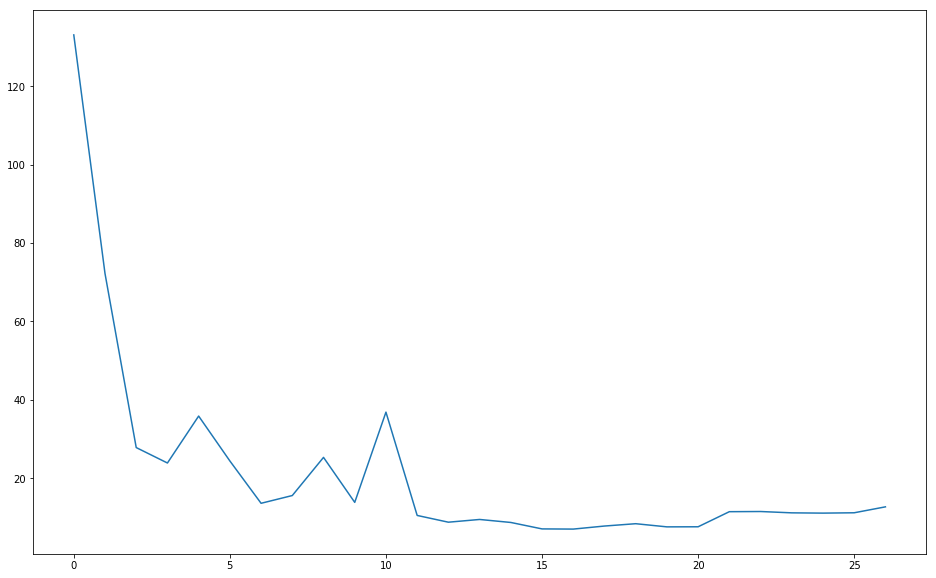

In [32]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(u_errors_matrix[0])
#plt.plot(c_ind_error)
plt.show()

In [146]:
np.array(u_errors_matrix)

array([[ 120.50553849,   69.33300448,   39.23126048,   24.56743535,
         114.73446446,   18.97193509,   24.54977661,   15.2157244 ,
          16.55055742,   18.74317989,   12.0495602 ,   11.95710951,
          11.00162658,   12.82591794,    9.41836339,   13.99090467,
          12.59388701,    8.16901013,    9.01311162,    8.83940604,
           8.57435572,    8.63230778,    8.64802911,    8.65123094,
           8.67079743,    8.69655673,    8.71869399,    8.74382999]])

In [19]:
pred_ind_all = independent_predictions(x_test, u_model)

In [20]:
pred_ind = pred_ind_all[:, 0:n_nodes]
ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])

In [21]:
print(ind_error)

13.5127575954


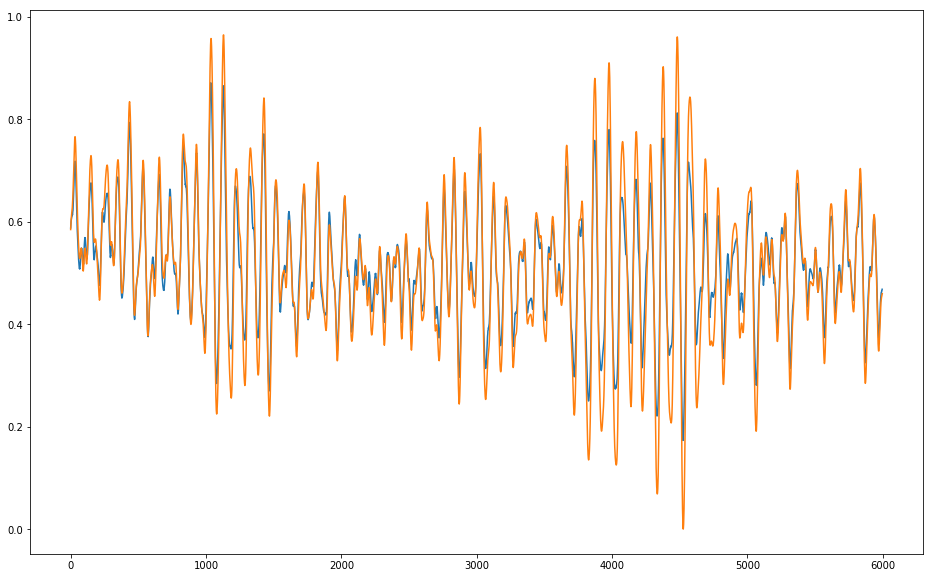

In [22]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_test[:, n_nodes-1])
plt.show()

In [26]:
def generate_export(my_model):
    pred_train_all = my_model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]

    pred_test_all = my_model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]

    pred_ind_all = independent_predictions(x_test, my_model)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]

    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    #Export results
    np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
    np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
    np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
    np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [27]:
generate_export(u_model)

In [42]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

NameError: name 'pred_test_u' is not defined

In [232]:
# one layer, height 500, gives lowest error around 9, but this is while its heavily overfitting
# one layer, height 100, on gr_set1 goes down to about 6 at epoch 40, then starts overfitting
# same, but with height 200 starts oscillating around batch 20, then the ind error is around 9. 
# With dropout 0.1 the results are bad


#df = df.drop(columns=df.columns[0])
#df.to_csv('../results/RNN_velocity_results.csv')

In [233]:
#pd.read_csv('../results/RNN_velocity_results.csv', index_col=0)

,training set,n_layers,height,epochs,batch size,learning rate,early stopping,stop loss,Training Error,Test Error,Ind test error,Ind train error,Training time,Total time
0,rr,2,100,500,1000,0.0005,115,0.005931,0.428430,0.102271,4.126604,19.038270,2173.341693,2263.469776
1,rr,2,100,500,1000,0.0001,36,0.005536,0.457434,0.111018,18.604378,96.249718,707.928417,803.638126
2,rr,3,50,500,1000,0.0005,160,0.013542,0.497549,0.108562,11.480535,70.656266,5234.750504,5392.588225


In [129]:
#save best model
#trained on= gr_set1

#model.save('../models/RNN_gr_set1.h5')

#### CONTINUE TRAINING ####
#model = load_model('beam_model.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

In [25]:
######################### BATCH TESTING ########################################

n_batches = 1
#d = 8

t0 = time.time()
for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/rrD' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/rrF' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/rrDt' + str(iteration+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    #if i == 0:
    #    model, callback_list = initialize_model(100, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    
    training_time = time.time() - ts
    
    pred_train_all = u_model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    #plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()

    
    total_time = time.time() - t0
    
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

NameError: name 'model' is not defined

In [23]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

NameError: name 'pred_test_u' is not defined

In [203]:
pred_ind_all = independent_predictions(x_train)
pred_ind = pred_ind_all[:, 0:n_nodes]

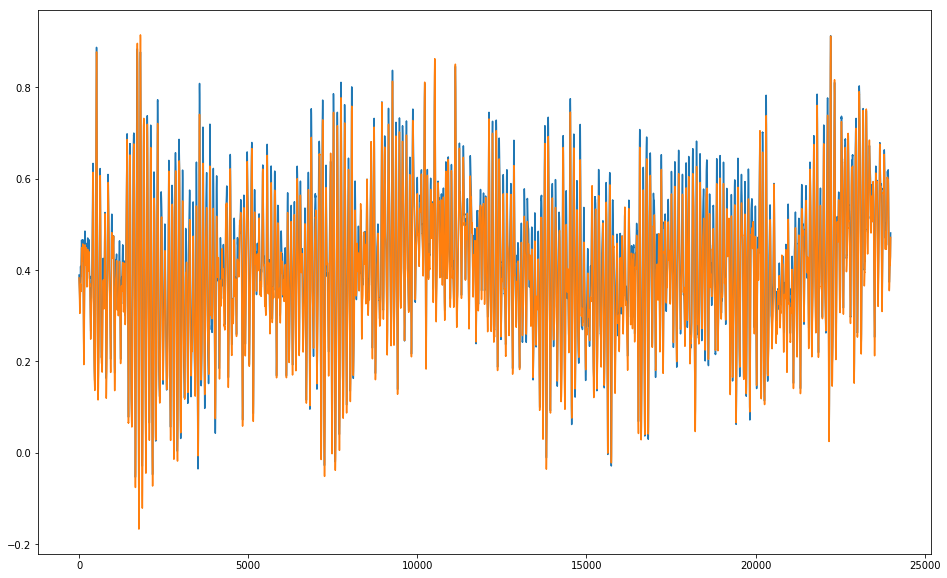

In [204]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [89]:
DF.shape

(4995, 205)

In [91]:
df_D.values.shape

(5000, 21)

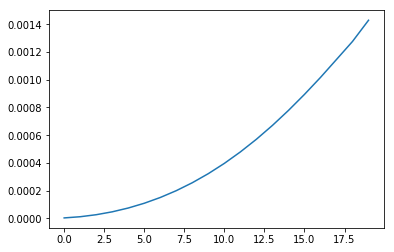

In [20]:
plt.plot(y_test_u[50,:])